# In this notebook we apply PCA and KMeans to the raw Ising configurations

In [223]:
import sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import numpy as np  # package fo}r arrays
import matplotlib.pyplot as plt  # package for plotting
from time import time 
import random as ran

In [224]:
def get_details(y):
    temps = set(y)
    temps = np.sort(np.array(list(temps)))
    np.sort([1,])
    Tcount = {}
    for kT in temps:
        Tcount[kT] = np.count_nonzero(y==kT)
    return Tcount

def order_data(y, X):
    indices = np.argsort(y)
    y = y[indices]
    X = X[indices]
    return (y, X)

def reconstruct_lattice(lattice):
    L = round(np.sqrt(len(lattice)))
    return np.reshape(lattice, (L,L))

def show_state(state):
    img = reconstruct_lattice(state)
    _, ax = plt.subplots()
    ax.imshow(img, cmap=plt.get_cmap('gray'), interpolation="nearest")
    
def load_data(method, L, x):
    path = 'data/'+method+'/L='+str(L)+'_x='+str(x)
    X = np.loadtxt(path+'_X.txt') 
    y = np.loadtxt(path+'_y.txt') 

    y, X = order_data(y, X)
    return y, X

In [225]:
def mean_absolute(y, values, central_limit=True):
    temperatures = list(set(y))
    
    means = []
    errs = []
    for kT in temperatures:
        filt = y==kT
        samples = values[filt]
        N_samples = len(samples)
        
        samples = np.abs(samples)
        mean = np.mean(samples)
        if central_limit:
            err = np.std(samples)/np.sqrt(N_samples)
        else:
            err = np.std(samples)
        
        errs.append(err)
        means.append(mean)
        
    return temperatures, means, errs
    
def reorder(temperatures, values, errs='None'):
    temperatures = np.array(temperatures)
    values = np.array(values)
    errs = np.array(errs)
    
    indices = np.argsort(temperatures)
    
    if errs != 'None':
        return temperatures[indices], values[indices], errs[indices]
    
    return temperatures[indices], values[indices]

def get_mean_errs(values, central_limit=True):
    mean = np.mean(values)
    if central_limit:
        err = np.std(values)/np.sqrt(len(values))
    else:
        err = np.std(values)
    return mean, err

# Loading Data

In [226]:
x = 0.8

y50, X50 = load_data(method='up_down', L=50, x=x)
y40, X40 = load_data(method='up_down', L=40, x=x)
y30, X30 = load_data(method='up_down', L=30, x=x)

print(y50.shape)
get_details(y50)

(1800,)


{0.7: 85,
 0.8: 78,
 0.9: 87,
 1.0: 88,
 1.1: 84,
 1.2: 92,
 1.3: 82,
 1.4: 82,
 1.5: 93,
 1.6: 80,
 1.7: 101,
 1.8: 108,
 1.9: 95,
 2.0: 91,
 2.1: 82,
 2.2: 74,
 2.3: 98,
 2.4: 99,
 2.5: 96,
 2.6: 105}

# Applying PCA

In [228]:
pca = PCA().fit(X50)
reduced_data = pca.transform(X50)
p1 = reduced_data[:, 0]
p2 = reduced_data[:, 1]
y = y50

In [229]:
temperatures, p1_mean, err1 = mean_absolute(y, p1)
temperatures, p2_mean, err2 = mean_absolute(y, p2)

temperatures, p1_mean, err1 = reorder(temperatures, p1_mean, err1)
temperatures, p2_mean, err2 = reorder(temperatures, p2_mean, err2)

/var/folders/v_/fs61ry8x6h9dg62cykggbxh00000gn/T/ipykernel_88232/181210518.py:30: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if errs != 'None':


Text(0.1, 0.9, '(d)')

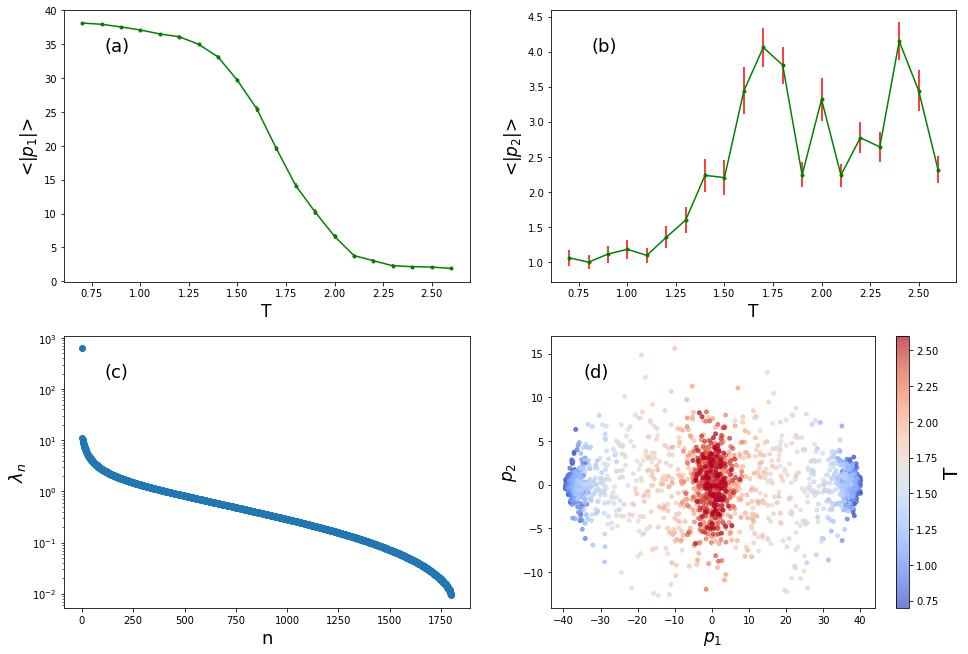

In [230]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,11))

# p1
axs[0][0].plot(temperatures, p1_mean, color='green')
axs[0][0].errorbar(temperatures, p1_mean, yerr=err1, fmt='.', color='green', ecolor='red')

axs[0][0].set_ylabel(r'<|$p_1$|>', fontsize=17)
axs[0][0].set_xlabel('T', fontsize=17)

p2_mean

# p2
axs[0][1].plot(temperatures, p2_mean, color='green')
axs[0][1].errorbar(temperatures, p2_mean, yerr=err2, fmt='.', color='green', ecolor='red')
axs[0][1].set_ylabel(r'<|$p_2$|>', fontsize=17)
axs[0][1].set_xlabel('T', fontsize=17)

# Eigenvalues
axs[1][0].scatter(np.arange(1, pca.n_components_ + 1)[:-1], pca.explained_variance_[:-1])
axs[1][0].set_yscale('log')
axs[1][0].set_xlabel('n', fontsize=18)
axs[1][0].set_ylabel(r'$\lambda_n$', fontsize=18)

# p1 vs p2
scatter = axs[1][1].scatter(p1, p2, c=y, cmap='coolwarm', alpha=0.7, s=15)
axs[1][1].set_ylabel(r'$p_2$', fontsize=17)
axs[1][1].set_xlabel(r'$p_1$', fontsize=17)

cbar = fig.colorbar(scatter)
cbar.set_label('T', fontsize=20)

axs[0,0].text(0.1, 0.9, "(a)", transform=axs[0,0].transAxes, fontsize=18, va='top')
axs[0,1].text(0.1, 0.9, "(b)", transform=axs[0,1].transAxes, fontsize=18, va='top')
axs[1,0].text(0.1, 0.9, "(c)", transform=axs[1,0].transAxes, fontsize=18, va='top')
axs[1,1].text(0.1, 0.9, "(d)", transform=axs[1,1].transAxes, fontsize=18, va='top')

In [231]:
# fig.savefig('./results/dilute_ising/[1]/PCA_edit.png')

# Kmeans Clustering

In [232]:
kmeans = KMeans(init="k-means++", n_clusters=3, n_init=4)
kmeans.fit(reduced_data)

KMeans(n_clusters=3, n_init=4)

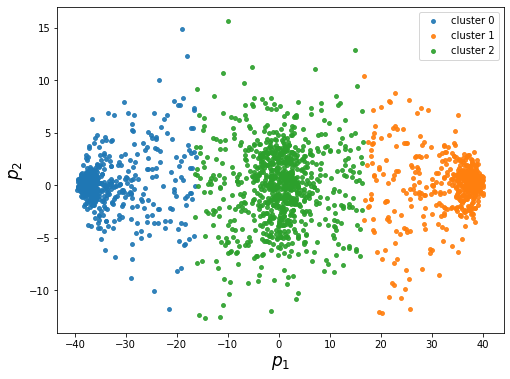

In [233]:
fig, ax = plt.subplots(figsize=(8, 6))

cluster0 = reduced_data[kmeans.labels_ == 0]
cluster1 = reduced_data[kmeans.labels_ == 1]
cluster2 = reduced_data[kmeans.labels_ == 2]

ax.scatter(cluster0[:, 0], cluster0[:, 1], alpha=0.9, s=15, label='cluster 0')
ax.scatter(cluster1[:, 0], cluster1[:, 1], alpha=0.9, s=15, label='cluster 1')
ax.scatter(cluster2[:, 0], cluster2[:, 1], alpha=0.9, s=15, label='cluster 2')

ax.set_ylabel(r'$p_2$', fontsize=17)
ax.set_xlabel(r'$p_1$', fontsize=17)
ax.legend()

# text = ax.text(0.02, 0.93, r"$T_c = 2.39 \pm 0.02 $", transform=ax.transAxes, fontsize=13, va='top',
#                bbox=dict(facecolor='none', edgecolor='black', linestyle='--', linewidth=1))

In [234]:
# fig.savefig('./results/dilute_ising/[2]/kmeans.png')

In [206]:
above_label = 0

# Labels
labels = []
for e in kmeans.labels_:
    if e==above_label:
        labels.append(1)
    else:
        labels.append(0)
x = np.array(labels)

# Finding Change Point

We estimate the critical temperature using the cluster labels as follows; 

The total number of data-points in the central (high temperature) cluster and the collective side (low temperature) clusters are $n_h, n_l$ respectively. For each temperature, $T_i$, count the number of data-points in the high temperature cluster, $n_{h, i}$ and in low temperature clusters, $n_{l, i}$

Then the probability of temperature, $T_i$, being higher than the critical temperature is:

$$ P(T_i>T_c) = \frac{(n_{h, i}/n_{h})}{(n_{l, i}/n_{l}) + (n_{h, i}/n_{h})} $$

We then convert this to the weight of temperature, T, via:

$$ Weight(T) = 1 - 2|0.5-P(T>T_c)| $$

This weight was chosen such that the closer $P(T>T_c)$ is to 0.5, the more likely it is to be the critical temperature so the higher the weight.

Then we find the critical temperature by taking the weighted mean of the temperatures, and we use the standard error of the weighted mean as the error for $T_c$

In [207]:
# y
# x where 0 is below and 1 is above

temperatures = list(set(list(y)))

total_above = np.count_nonzero(x)
total_below = len(x) - total_above

probabilities = []
for T in temperatures:
    x_ = x[y==T]
    n_above = np.count_nonzero(x_)
    n_below = len(x_) - n_above
    prep_above = n_above/total_above
    prep_below = n_below/total_below
    probability = prep_above/(prep_above+prep_below)
    probabilities.append(probability)
    
weights = []
for i,p in enumerate(probabilities):
    weight = 1-abs(0.5-p)*2
    print(temperatures[i], '  ', round(p,3), '  ', round(weight,3))
    weights.append(weight)
    
data = temperatures

weighted_mean = np.average(data, weights=weights)

# Calculate the standard error of the weighted mean
weighted_variance = np.average((data - weighted_mean) ** 2, weights=weights)
weighted_std_error = np.sqrt(weighted_variance / len(data))

print('')
print(weighted_mean)
print(weighted_std_error)

print('lowest "above" labels: ', y[x==1][0], y[x==1][1], y[x==1][2], y[x==1][3])
print('highest "below" labels: ', y[x==0][-1], y[x==0][-2], y[x==0][-3], y[x==0][-4])

0.7    0.0    0.0
0.8    0.0    0.0
1.1    0.0    0.0
1.0    0.0    0.0
0.9    0.0    0.0
1.2    0.0    0.0
1.3    0.0    0.0
1.4    0.0    0.0
1.5    0.042    0.085
1.6    0.086    0.172
1.7    0.344    0.688
2.0    0.966    0.069
2.5    1.0    0.0
2.1    0.993    0.015
2.6    1.0    0.0
2.2    1.0    0.0
2.3    1.0    0.0
1.8    0.619    0.762
1.9    0.793    0.414
2.4    1.0    0.0

1.7686519615091643
0.024964535127640658
lowest "above" labels:  1.5 1.5 1.5 1.6
highest "below" labels:  2.1 2.0 2.0 2.0



#### x=0.8

L=30:
1.7686519615091643
0.024964535127640658

L=40:
1.7588003745057057
0.017654819922389216

L=50:
1.765416057067977
0.015770783755770245


In [208]:
def m_c(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    
    m = (y2-y1)/(x2-x1)
    c = y1 - m*x1
    
    return m,c

Y-intercept: 1.755418877551019 +/- 0.07677500000000004
lower bound: 1.68


Text(0.05, 0.9, '$T_c = 1.76 \\pm 0.08 $')

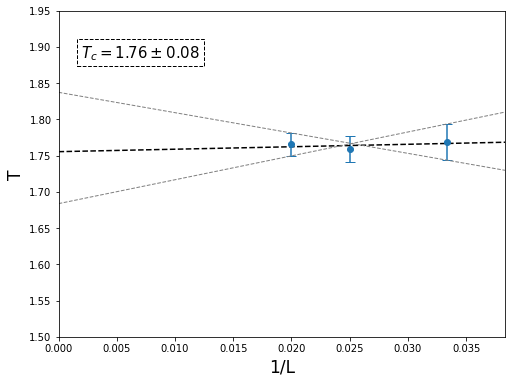

In [221]:
import numpy as np
import matplotlib.pyplot as plt

T = np.array([1.7654, 1.7588, 1.76865])
errs = np.array([0.01577, 0.0177, 0.0249])
_L = np.array([1/50, 1/40, 1/30])

fit = np.polyfit(_L, T, 1)
fit_fn = np.poly1d(fit)

lower1 = _L[0] - errs[0]
higher1 = _L[0] + errs[0]

m1,c1 = m_c((_L[0], T[0] - errs[0]), (_L[1], T[1] + errs[1]))
m2,c2 = m_c((_L[0], T[0] - errs[0]), (_L[2], T[2] + errs[2]))
lower = ()
if c1>c2:
    lower = (m1, c1)
else:
    lower = (m2, c2)

m1,c1 = m_c((_L[0], T[0] + errs[0]), (_L[1], T[1] - errs[1]))
m2,c2 = m_c((_L[0], T[0] + errs[0]), (_L[2], T[2] - errs[2]))
higher = ()
if c1<c2:
    higher = (m1, c1)
else:
    higher = (m2, c2)

print("Y-intercept:", fit[1], "+/-", (higher[1]-lower[1])/2)

print("lower bound:", round(fit[1],2) - round((higher[1]-lower[1])/2, 2),)

fig, ax = plt.subplots(figsize=(8,6))

ax.set_xlim([0, max(_L)+0.005])
ax.set_ylim([1.5, 1.95])

ax.errorbar(_L, T, yerr=errs, fmt='o', capsize=5)

m,c = m_c((0, fit[1]),(_L[-1], fit_fn(_L)[-1]))
ax.plot([0, max(_L) + 0.005], [fit[1], m*(max(_L) + 0.005) + c], '--', color='black')

ax.plot([0, max(_L)+0.005], [lower[1], lower[0]*(max(_L)+0.005) + lower[1]], '--', linewidth=1, color='grey')
ax.plot([0, max(_L)+0.005], [higher[1], higher[0]*(max(_L)+0.005) + higher[1]], '--', linewidth=1, color='grey')
ax.set_xlabel('1/L', fontsize=17)
ax.set_ylabel('T', fontsize=17)

ax.text(0.05, 0.9, r"$T_c = 1.76 \pm 0.08 $", transform=ax.transAxes, fontsize=15, va='top',
               bbox=dict(facecolor='none', edgecolor='black', linestyle='--', linewidth=1))

In [222]:
# fig.savefig('./results/dilute_ising/[2]/finite_scaling.png')

In [54]:
m_c((_L[0], T[0] - errs[0]), (_L[1], T[1] + errs[1]))

(6.345180000000016, 2.2576383999999994)

In [63]:
2.3429677510204066 - 0.057

2.2859677510204066